# Comparison of operations woth OOMMF

In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc
import numpy as np

Sample

In [2]:
p1=(0, 0, 0)
p2=(4e-9, 8e-9, 10e-9)
cell = (1e-9, 1e-9, 1e-9)

region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell, bc='neumann') 

Parameters

In [3]:
Ms = 1e6
A = 1e-12
D = 1e-3
K = 1e5
u = (0, 0, 1)
H = (1e6, 0, 0)
mu0 = 4 * np.pi * 1e-7

Magnetisation field

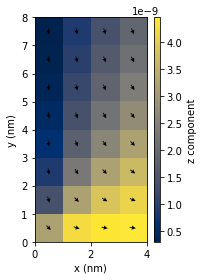

In [28]:
def m_value(point):
    x, y, z = point
    c = 1e9
    return (c*x, -c*y, c*z*x)

M = df.Field(mesh, dim=3, value=m_value, norm=Ms)
m = M.orientation

m.plane('z').mpl()

In [29]:
system = mm.System(name='mysystem')
system.energy = (mm.Exchange(A=A) + mm.DMI(D=D, crystalclass='T') +
                 mm.UniaxialAnisotropy(K=K, u=u) + mm.Zeeman(H=H))
system.m = M

## Zeeman

#### Energy density

In [30]:
wdf = - mu0 * Ms * m @ H
woc = oc.compute(system.energy.zeeman.density, system)
np.allclose(wdf.array, woc.array)

Running OOMMF (ExeOOMMFRunner) [2020/06/04 18:48]... (1.8 s)


True

#### Energy

In [31]:
Edf = (- mu0 * Ms * m @ H).integral
Eoc = oc.compute(system.energy.zeeman.energy, system)
print(f'df: {Edf}')
print(f'oc: {Eoc}')
print(f'rerr: {abs(Edf-Eoc)/Edf * 100} %')

Running OOMMF (ExeOOMMFRunner) [2020/06/04 18:48]... (1.8 s)
df: -1.9413017194616356e-19
oc: -1.94130171946e-19
rerr: -8.425253987435017e-11 %


#### Effective field

In [32]:
Hdf = df.Field(mesh, dim=3, value=H)
Hoc = oc.compute(system.energy.zeeman.effective_field, system)
np.allclose(Hdf.array, Hoc.array)

Running OOMMF (ExeOOMMFRunner) [2020/06/04 18:48]... (1.7 s)


True

## Uniaxial anisotropy

#### Energy density

In [33]:
wdf = - K * (m @ u)**2
woc = oc.compute(system.energy.uniaxialanisotropy.density, system)
np.allclose(wdf.array, woc.array)

Running OOMMF (ExeOOMMFRunner) [2020/06/04 18:48]... (1.8 s)


False

#### Energy

In [34]:
Edf = (K * (m @ u)**2).integral
Eoc = oc.compute(system.energy.uniaxialanisotropy.energy, system)
print(f'df: {Edf}')
print(f'oc: {Eoc}')
print(f'rerr: {abs(Edf-Eoc)/Edf * 100} %')

Running OOMMF (ExeOOMMFRunner) [2020/06/04 18:48]... (1.8 s)
df: 3.322892655943544e-37
oc: 3.2e-20
rerr: 9.630163629499947e+18 %


#### Effective field

In [35]:
Hdf = 2 * K / (mu0 * Ms) * (m @ u)
Hoc = oc.compute(system.energy.uniaxialanisotropy.effective_field, system)
np.allclose(Hdf.array, Hoc.array)

Running OOMMF (ExeOOMMFRunner) [2020/06/04 18:48]... (1.8 s)


False

## Exchange

#### Energy density

In [36]:
wdf = - A * m @ m.laplacian
woc = oc.compute(system.energy.exchange.density, system)
np.allclose(wdf.array, woc.array)

Running OOMMF (ExeOOMMFRunner) [2020/06/04 18:49]... (2.0 s)


True

#### Energy

In [37]:
Edf = (- A * m @ m.laplacian).integral
Eoc = oc.compute(system.energy.exchange.energy, system)
print(f'df: {Edf}')
print(f'oc: {Eoc}')
print(f'rerr: {abs(Edf-Eoc)/Edf * 100} %')

Running OOMMF (ExeOOMMFRunner) [2020/06/04 18:49]... (1.8 s)
df: 2.0830618544079488e-20
oc: 2.08306185441e-20
rerr: 9.846636989833302e-11 %


#### Effective field

In [38]:
Hdf = 2 * A / (mu0 * Ms) * m.laplacian
Hoc = oc.compute(system.energy.exchange.effective_field, system)
np.allclose(Hdf.array, Hoc.array)

Running OOMMF (ExeOOMMFRunner) [2020/06/04 18:49]... (1.8 s)


True

## DMI

#### Energy density

In [39]:
wdf = A * m @ m.curl
woc = oc.compute(system.energy.dmi.density, system)
np.allclose(wdf.array, woc.array)

Running OOMMF (ExeOOMMFRunner) [2020/06/04 18:49]... (1.8 s)


False

#### Energy

In [40]:
Edf = (A * m @ m.curl).integral
Eoc = oc.compute(system.energy.dmi.energy, system)
print(f'df: {Edf}')
print(f'oc: {Eoc}')
print(f'rerr: {abs(Edf-Eoc)/Edf * 100} %')

Running OOMMF (ExeOOMMFRunner) [2020/06/04 18:49]... (1.9 s)
df: 2.3195104165146195e-37
oc: 2.31951041462e-28
rerr: 99999999818.31813 %


#### Effective field

In [41]:
Hdf = - 2 * D / (mu0 * Ms) * m.curl
Hoc = oc.compute(system.energy.dmi.effective_field, system)
np.allclose(Hdf.array, Hoc.array)

Running OOMMF (ExeOOMMFRunner) [2020/06/04 18:49]... (1.8 s)


False

In [18]:
Hdf.array

array([[[[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-1.34178239e+05,  1.34178239e+05, -0.00000000e+00],
         [-3.53221655e+04,  3.53221655e+04, -0.00000000e+00],
         [-1.09913580e+04,  1.09913580e+04, -0.00000000e+00],
         [-4.32826489e+03,  4.32826489e+03, -0.00000000e+00],
         [-2.01347944e+03,  2.01347944e+03, -0.00000000e+00],
         [-1.05472467e+03,  1.05472467e+03, -0.00000000e+00],
         [-6.03209405e+02,  6.03209405e+02, -0.00000000e+00],
         [-3.68983548e+02,  3.68983548e+02, -0.00000000e+00],
         [ 3.72094218e+03, -3.72094218e+03, -0.00000000e+00]],

        [[ 1.34178239e+05, -0.00000000e+00, -1.34178239e+05],
         [-0.00000000e+00,  1.71756523e+04, -1.71756523e+04],
         [-2.83057560e+04,  1.31823422e+04, -2.24825415e+03],
         [-1.64736665e+04,  6.41879915e+03, -3.97532992e+02],
         [-8.46705585e+03,  3.10048630e+03, -9.27114518e+01],
         [-4.52241459e+03,  1.60613974e+03, -2.69095105e+01],
      

In [19]:
Hoc.array

array([[[[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-8.53983552e+05,  8.53983552e+05, -0.00000000e+00],
         [-8.01056742e+05,  8.01056742e+05, -0.00000000e+00],
         [-7.91006598e+05,  7.91006598e+05, -0.00000000e+00],
         [-7.90456870e+05,  7.90456870e+05, -0.00000000e+00],
         [-7.91291966e+05,  7.91291966e+05, -0.00000000e+00],
         [-7.92162099e+05,  7.92162099e+05, -0.00000000e+00],
         [-7.92864554e+05,  7.92864554e+05, -0.00000000e+00],
         [-7.93404363e+05,  7.93404363e+05, -0.00000000e+00],
         [-8.31625869e+05,  8.31625869e+05, -0.00000000e+00]],

        [[ 8.53983552e+05, -0.00000000e+00, -8.53983552e+05],
         [-0.00000000e+00,  5.64865373e+05, -5.64865373e+05],
         [-2.83057560e+04,  6.85734729e+05, -4.05779686e+05],
         [-1.64736665e+04,  7.31626104e+05, -3.11200664e+05],
         [-8.46705585e+03,  7.53879197e+05, -2.50352282e+05],
         [-4.52241459e+03,  7.66404897e+05, -2.08608389e+05],
      